In [1]:
!which python

/usr/bin/python


In [1]:
import sys
import os
sys.path.append(os.getcwd())  # Replace with actual path

import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from model_efficientnet import build_model
# from model_st import build_model
from datasets import get_datasets, get_data_loaders
from utils import save_model, save_plots
import torchvision.models as models

In [2]:
# Learning_parameters. 
lr = 0.00001
epochs = 5
pretrained = True
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

Computation device: cuda
Learning rate: 1e-05
Epochs to train for: 5



In [3]:
# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
# Load the training and validation datasets.
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets(pretrained)
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")

# Load the training and validation data loaders.
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

[INFO]: Number of training images: 10244
[INFO]: Number of validation images: 1281
[INFO]: Class names: ['Noise', 'Drone']



In [5]:
model = build_model(
    pretrained=pretrained, 
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)

# Loss function.
criterion = nn.CrossEntropyLoss()


605,042 total parameters.
605,042 training parameters.


[INFO]: Epoch 1 of 5
Training


  0%|          | 0/641 [00:05<?, ?it/s]


too many values to unpack (expected 2)
TRAINING COMPLETE
Test
Validation


  0%|          | 0/81 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

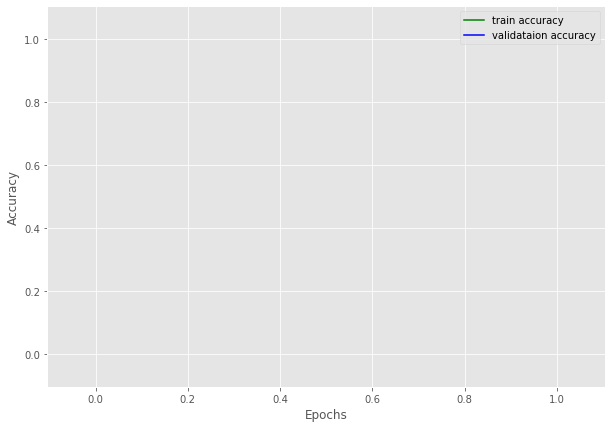

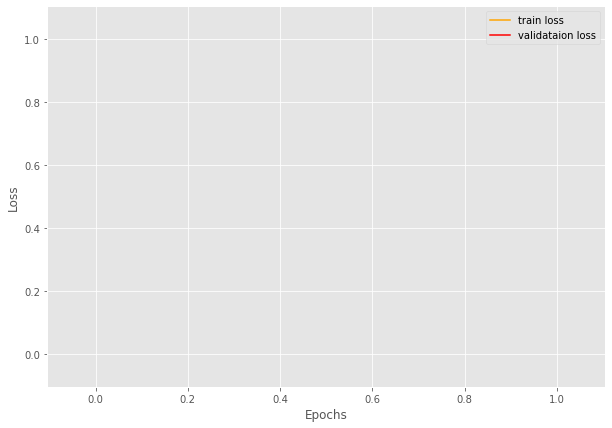

In [8]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
try:
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                    criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)
        time.sleep(5)

except Exception as e:
    print(e)
    pass

# Save the trained model weights.
save_model(epochs, model, optimizer, criterion, pretrained)

# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained)
print('TRAINING COMPLETE')

# Test model on test set
print("Test")
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test loss: {test_loss:.3f}, test acc: {test_acc:.3f}")


In [9]:
def load_model():
    # Define the model (should match the saved model's architecture)
#     model = models.efficientnet_b0(pretrained=False)  # Change to your model
#     num_classes = 2  # Set this based on your model
#     model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    model = build_model()

    # Load the trained weights
    model.load_state_dict(torch.load("../outputs/efficientnet_b0.pth", map_location=device)["model_state_dict"])
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning first layer & last 20 layers...
Precision: 0.8626
Recall: 0.9098


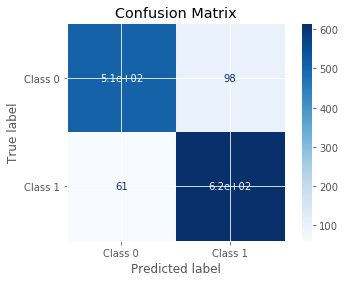

In [10]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []
all_filenames = []

# Validation Loop
model = load_model()
with torch.no_grad():
    for data in test_loader:
        image, labels, filename = data
        image = image.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(image)
        
        # Get predicted class labels
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Convert to numpy and store
        all_labels.extend(labels.cpu().numpy())
        all_filenames.extend(filename)

# Compute precision and recall
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

# Print precision and recall
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Check for False Negatives: True label = 1, Predicted label = 0
fn_filenames = []

for idx in range(len(all_labels)):
    if all_labels[idx] == 1 and all_preds[idx] == 0:  # False Negative condition
        fn_filenames.append(all_filenames[idx])  # Store the filename of FN

print("Filenames with False Negatives:")
i = 0
for filename in fn_filenames:
    i += 1
    print(filename)
    if i == 61:
        break

Filenames with False Negatives:
/home/dsta/Desktop/City_Data/Test/Drone/FSDrone5820_npy_usrp_samples_843.npy
/home/dsta/Desktop/City_Data/Test/Drone/SLoc_Drone_5820_npy_usrp_samples_956.npy
/home/dsta/Desktop/City_Data/Test/Drone/S2_drone_5820_npy_usrp_samples_99.npy
/home/dsta/Desktop/City_Data/Test/Drone/Pandan_mavic2_5.793.5Ghz_20M_200m_downlink_101220_usrp_samples_73.npy
/home/dsta/Desktop/City_Data/Test/Drone/S2_drone_5780_npy_usrp_samples_514.npy
/home/dsta/Desktop/City_Data/Test/Drone/SLoc_Drone_v2_5820_npy_usrp_samples_36.npy
/home/dsta/Desktop/City_Data/Test/Drone/Phamtom4_16_low_26Nov_E_Day1_Evening_iq_data_50.npy
/home/dsta/Desktop/City_Data/Test/Drone/SLoc_Drone_5780_npy_usrp_samples_408.npy
/home/dsta/Desktop/City_Data/Test/Drone/MavicPro_2440_low_14Dec_A_Day14_Afternoon-Set7_iq_data_205.npy
/home/dsta/Desktop/City_Data/Test/Drone/S2_drone_5820_npy_usrp_samples_445.npy
/home/dsta/Desktop/City_Data/Test/Drone/mavicair_11_200m_m_1_Pandan_260619_iq_data_99.npy
/home/dsta/Desk

In [31]:
# !pip install torchinfo
from torchinfo import summary

model = build_model(pretrained=False)
summary(model, input_size=(1, 3, 224, 224))

[INFO]: Not loading pre-trained weights
[INFO]: Fine-tuning first layer & last 20 layers...


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─ConvNormActivation: 2-1                          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [35]:
input_tensor = torch.randn(30, 3, 224, 224)  # Batch size 1, 1 channel, 256x1024
model = build_model(pretrained=False)

# Measure CPU time
model = model.to("cpu")

start_time = time.time()
output = model(input_tensor)  # Run inference
end_time = time.time()

cpu_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"CPU Inference Time: {cpu_time:.3f} ms")

# Warm-up GPU (avoids cold-start overhead)
model = model.to("cuda")
input_tensor = input_tensor.to("cuda")
for _ in range(10):
    _ = model(input_tensor)

# Measure GPU time
torch.cuda.synchronize()  # Ensure previous operations finish
start_time = torch.cuda.Event(enable_timing=True)
end_time = torch.cuda.Event(enable_timing=True)

start_time.record()
output = model(input_tensor)  # Run inference
end_time.record()

torch.cuda.synchronize()  # Wait for GPU to finish
gpu_time = start_time.elapsed_time(end_time)  # Get elapsed time in ms
print(f"GPU Inference Time: {gpu_time:.3f} ms")

[INFO]: Not loading pre-trained weights
[INFO]: Fine-tuning first layer & last 20 layers...
CPU Inference Time: 8083.951 ms
GPU Inference Time: 89.514 ms
